In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib widget
# %matplotlib inline

DATAFILE = "data/Messaussetzer_data_in.dat"
df = pd.read_csv(DATAFILE, sep=" ")
t = df["time"].to_numpy()
y = df["position"].to_numpy()
u = np.zeros(len(y))
Ts = t[1] - t[0]

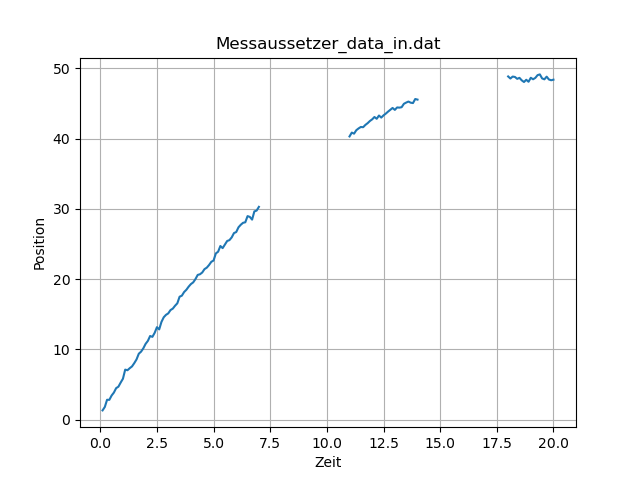

In [29]:
plt.figure()
plt.title("Messaussetzer_data_in.dat")
plt.xlabel("Zeit")
plt.ylabel("Position")
plt.grid(True)
plt.plot(t, y)
plt.show()

In [30]:
y_filtered = []
for i in range(len(t)):
    if str(y[i]) == "nan":
        break
    else:
        y_filtered.append(y[i])

y_rand_var = []
for i in range(0, 3, 1):
    y_rand_temp = random.choices(y_filtered[0:len(y_filtered)], k=50)

    y_rand_var.append(np.var(y_rand_temp))

print(np.var(y_rand_var))

R = min(y_rand_var)
Q = [0.00016667]
print(f"R={R}, Q={Q}")

non_nan = ~np.isnan(y)
R = np.var(y[np.argwhere(non_nan == False)[-1][0] + 1 :])
print(f"R={R}, Q={Q}")

26.003327217675135
R=59.99339766300702, Q=[0.00016667]
R=0.07515963685972159, Q=[0.00016667]


In [31]:
# Define system matrices
Ad = np.array([[1, Ts],
               [0, 1]])
Bd = np.array([[0],
               [0]])
C = np.array([1, 0])
D = np.array([0])
Gd = np.array([[Ts],
               [1]])
               
# Initialization
x_dach = np.array([[y[0]], [0]])    # estimate
P_dach = 30 * np.eye(Bd.size)

s = np.zeros(len(y))                # prediction output array
v = np.zeros(len(y))                # variation
u = np.zeros(len(y))
d_y = np.zeros(len(y))              # new error
s_dach = np.zeros(len(y))
y_dach = np.zeros(len(y))           # error

P_tilde0 = np.zeros(len(y))
P_tilde1 = np.zeros(len(y))
P_tilde2 = np.zeros(len(y))
P_tilde3 = np.zeros(len(y))

In [32]:
for i, y_i in enumerate(y):
    if np.isnan(y_i):
        x_tilde = x_dach
        P_tilde = P_dach
    else:
        y_dach[i] = (C @ x_dach + D * u[i])
        d_y[i] = y_i - y_dach[i]
        # K = P_dach @ C.reshape(-1,1) * (C @ P_dach @ C.reshape(-1,1) + R) ** (-1) # previous method
        k = C @ P_dach @ C.reshape(-1,1) + R
        if k.ndim >= 2:
            K = P_dach @ C.reshape(-1,1) @ np.linalg.pinv(k) # penrose inverse works with k dimension greater 2
        else:
            K = P_dach @ C.reshape(-1,1) / k # use plain inverse otherwise
    
        x_tilde = x_dach + K * d_y[i]
        P_tilde = (np.eye(Bd.size) - K * C) @ P_dach
    # print(P_tilde)

    x_dach = Ad @ x_tilde + Bd * u[i]
    P_dach = Ad @ P_tilde @ Ad.T + Gd @ Q * Gd.T

    s[i] , v[i] = x_tilde
    s_dach[i] = x_dach[0]

    P_tilde0 = P_tilde[0][0]
    P_tilde1 = P_tilde[0][1]
    P_tilde2 = P_tilde[1][0]
    P_tilde3 = P_tilde[1][1]

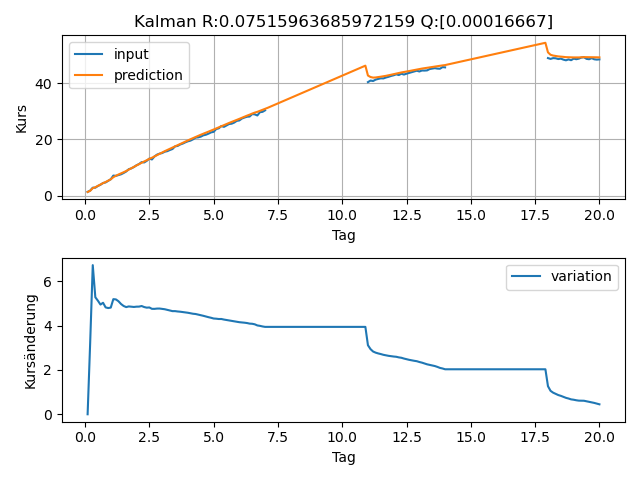

In [33]:
plt.figure()
plt.subplot(2, 1, 1)
plt.title(f"Kalman R:{R} Q:{Q}")
plt.xlabel("Tag")
plt.ylabel("Kurs")
plt.grid(True)
plt.plot(t, y, label="input")
plt.plot(t, s, label="prediction")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, v, label="variation")
plt.xlabel("Tag")
plt.ylabel("Kursänderung")
plt.legend()
plt.tight_layout()
plt.show()